## Introduction to `torch.autograd`

`torch.autograd`는 신경망 학습을 지원하는 PyTorch의 자동 미분 엔진으로, 별다른 수학적 수식의 구현 없이도 신경망 학습에 필요한 미분 계산을 수행할 수 있도록 도와준다.

### 배경

신경망은 어떤 입력 데이터에 대해 실행되는 nested 함수들의 collection이다. 이 함수들은 PyTorch에서 Tensor로 저장되는 가중치(weight)와 편향(bias)으로 구성된 매개변수들로 정의된다.

**순전파(Forward Propagation):** 순전파 단계는 입력층에서 출력층 방향으로 데이터가 흐르면서 차례대로 변수들을 계산하고 저장하는 것을 의미한다. 입력층과 출력층 사이에 존재하는 층을 은닉층(hidden layer)이라고 하고 이 과정을 거쳐 출력된 값과 실제 정답 간의 오차를 계산하는 것까지를 의미한다.

**역전파(Back Propagation):** 역전파는 순전파와 반대로 출력층에서 입력층 방향으로 전파되는 가중치 업데이트 과정이다. 이때 전파되는 정보는 순전파에서 계산된 전체 오차값으로, 미분의 연쇄법칙(Chain Rule)에 의해 계산되며 각 층의 가중치를 업데이트한다. 업데이트된 신경망에 대해 순전파를 다시 진행하며 오차가 감소하였는지를 확인하고 이를 반복한다.

### PyTorch에서의 사용

In [22]:
import torch
from torchvision.models import resnet18, ResNet18_Weights

In [23]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
data =  torch.rand(1,3,64,64)
labels = torch.rand(1,1000)

In [24]:
# Forward Propagation
prediction = model(data)

In [25]:
# Backward Propagation
loss = (prediction - labels).sum()
print(f'Current Loss: {loss}')

loss.backward()

Current Loss: -509.0367126464844
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [26]:
optim = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

In [27]:
optim.step()

### Autograd 에서 미분

In [32]:
a = torch.tensor([2.,3.], requires_grad=True)
b = torch.tensor([6.,4.], requires_grad=True)

$$Q = 3a^3 - b^2$$

In [33]:
Q = 3*a**3 - b**2

$${\partial Q\over \partial a} = 9a^2$$
$${\partial Q\over \partial b} = -2b$$

Q는 벡터이므로 `Q.backward()`에 `gradient` 인자를 명시적으로 전달해야 한다. `gradient`는 Q와 같은 shape의 Tensor로, Q 자기자싱에 대한 gradient를 나타낸다.

$${dQ\over dQ}=1$$

In [34]:
external_grad = torch.tensor([1.,1.])
Q.backward(gradient=external_grad)

In [36]:
print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


### `autograd`를 사용한 벡터 미적분

수학적으로, 벡터함수 $\vec{y} = f(\vec{x})$에서 $\vec{x}$에 대한 $\vec{y}$의 변화도는 Jacobian Matrx $J$와 같으며, 일반적으로 `torch.autograd`는 벡터-야코비안 곱을 계산하는 엔진이다. 이는 주어진 어떤 벡터 $\vec{v}$에 대해 $J^T * \vec{v}$를 연산한다.

### 연산 그래프(Computational Graph)

개념적으로, autograd는 데이터(텐서)와 실행된 모든 연산의 기록을 Function 객체로 구성된 방향성 비순환 그래프(Directed Acyclic Graph, DAG)에 저장한다. 이 DAG의 leaf는 입력 텐서이고 root는 결과 텐서로, autograd는 root에서부터 leaf 방향으로 chain rule에 따라 젼화도를 자동으로 계산한다.

순전파 단계에서 autograd는 요청된 연산을 수행하여 결과 텐서를 계산하고 `.backward()`가 호출되면서 시작되는 역전파 단계에서는 각 `.grad_fn`으로부터 변화도를 계산하고 각 텐서의 `.grad` 속성에 계산 결과를 축적하며 chain rule을 사용하여 모든 leaf 텐서들까지 오차를 전파한다.

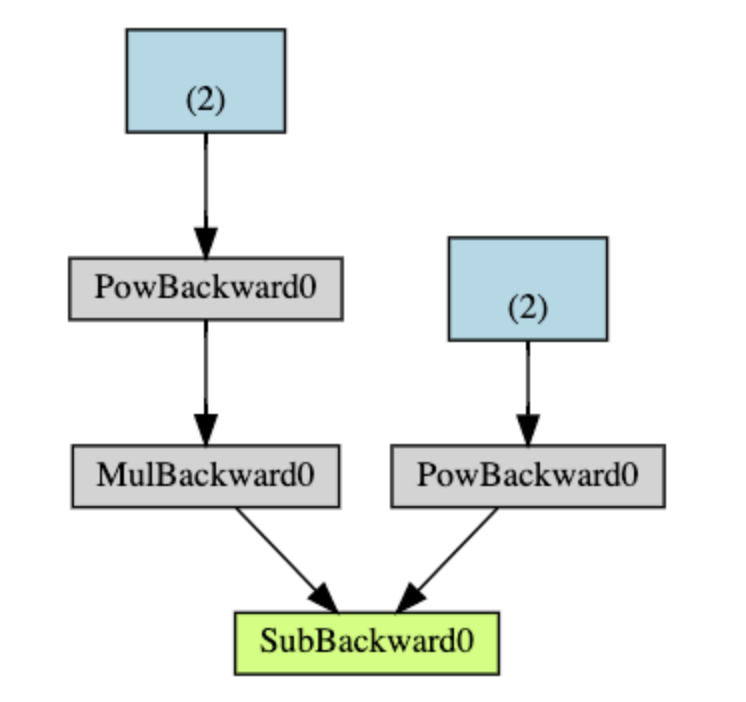

PyTorch에서 이러한 DAG들은 동적(dynamic) 그래프로, 데이터를 흘려보냄과 동시에()`.backward()`가 호출될 때마다) autograd는 새로운 그래프를 다시 생성한다. 동적 그래프를 사용하므로 정적 그래프 방식보다 약간 느리긴하지만 모델에서 control flow 구문을 사용할 수 있으며 별도 컴파일 없이 계산 그래프를 만들 수 있고, 디버깅이 쉽다는 장점이 존재한다.

### DAG에서 제외하기

`torch.autograd`는 `requires_grad` 플래그가 True로 설정된 모든 텐서에 대한 연산을 추적한다.따라서, 변화도가 필요하지 않은 텐서들에 대해서는 이 속성을 False로 설정하여 DAG 변화도 계산에서 제외할 수 있다.

입력 텐서 중 단 하나라도 `requires_grad`가 True인 경우 연산의 결과 텐서도 변화도를 갖게 된다.

In [38]:
x = torch.rand(5,5)
y = torch.rand(5,5)
z = torch.rand((5,5), requires_grad=True)

a = x+y
print(f"Does 'a' requires grad?: {a.requires_grad}")

b = x+z
print(f"Does 'b' requires grad?: {z.requires_grad}")

c = y+z
print(f"Does 'c' requires grad?: {z.requires_grad}")

Does 'a' requires grad?: False
Does 'b' requires grad?: True
Does 'c' requires grad?: True


위의 x, y, a 처럼 변화도를 계산하지 않는 매개변수를 일반적으로 `frozen parameter`라고 부른다. 이러한 방식으로 통해 신경망 모델의 일부를 freeze하여 학습 단계에서 가중치가 변화하지 않도록 할 수 있다. 

보통 finetuning의 과정에서 기학습된 pretrained 모델의 대부분을 freeze한 후 마지막 classifier layer 등에 대해서만 `requires_grad`를 True로 설정하여 변경한다. 

In [41]:
from torch import nn, optim

model = resnet18(weights=ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False

In [42]:
# Classifier layer of ResNet
model.fc = nn.Linear(512,18)

이제 `model.fc`를 제외한 모델의 모든 매개변수들이 고정되었다. 변화도를 계산하는 유일한 매개변수는 `model.fc`의 weight & bias 뿐이다.

In [43]:
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)